In [1]:
import numpy as np
import qat
from qat.core import Schedule
#from qat.qpus import AnalogQPU
from qlmaas.qpus import AnalogQPU

from time import time
import pickle

from qat.core.variables import Variable, heaviside

def create_waveform(times, values):
    """
    A Funnction allowing us to concatenate many lines, limited by heavisides,
    thus creating a continuous, kinked line.
    """
    assert len(times) == len(values)
    # Store the final line as an ArithExpression
    arith_expr = 0
    t_var = Variable("t")
    # A line between each two points
    for entry_i in range(1, len(times)):
        # Create ax + b by calculating the slope and the offset
        a = (values[entry_i] - values[entry_i - 1]) / (times[entry_i] - times[entry_i - 1])
        b = ((values[entry_i] + values[entry_i - 1]) - a * (times[entry_i] + times[entry_i - 1])) / 2
        respective_line = a * t_var + b
        arith_expr += heaviside(t_var, times[entry_i - 1], times[entry_i]) * respective_line
    return arith_expr
#

def occ_correlation(result, shape=None):
    """
    extract probability from result
    and compute spatial correlation
    """
    nqbits = result[0].qregs[0].length
    arr = np.zeros(nqbits)
    for sample in result:
        s = sample.state.bitstring
        prob = sample.probability
        n = np.array(list(s), dtype=int)
        arr += (1-2 * n) * prob
    if shape is not None:
        arr = arr.reshape(shape)
    return arr

def occ_op(nqbits, qi):
    ti = qat.core.Term(1.0, 'Z', [qi])
    return (1 + qat.core.Observable(nqbits, pauli_terms=[ti])) / 2
#

def setup_hamiltonian(L1, L2, R0, T_max, omega_max, Omega, delta, C6):
    nqbits = L1 * L2
    Ri = R0 * np.array(list(np.ndindex(L1, L2)))
    rij = np.array([np.linalg.norm(xi - xj)
                     for xi in Ri for xj in Ri]
                     ).reshape(nqbits, nqbits)
    np.fill_diagonal(rij, 1.0) # Avoid division by zero
    rij_inv = 1 / rij # Inverse of the distance matrix
    np.fill_diagonal(rij_inv, 0.0) # fill diagonal with zeros so it doens't contribute to the sum
    U = omega_max / 2
    omega_values = [0.0, omega_max , omega_max , 0]
    times = [0.0, 0.25, 0.5, T_max]
    omega_waveform = create_waveform(times, omega_values)
    # The waveform of the detuning Delta - for the 'n' terms
    delta_start = -6 * U
    delta_end = 2 * U # R_blockade is taken as 7.5
    delta_values = [delta_start, delta_start, delta_end, delta_end]
    delta_waveform = create_waveform(times, delta_values)
    #
    H1_terms = [qat.core.Term(1.0, "X", [i]) for i in range(nqbits)]
    H1 = qat.core.Observable(nqbits, pauli_terms=H1_terms)
    H2_terms = [qat.core.Term(-1.0, "Z", [i]) for i in range(nqbits)]
    H2 = qat.core.Observable(nqbits, pauli_terms=H2_terms)

    H3 = 0
    for i in range(nqbits):
        for j in range(i + 1, nqbits):
            H3 += (C6 * rij_inv[i, j]**6) * occ_op(nqbits, i) * occ_op(nqbits, j)

    schedule = Schedule(drive=[
        (omega_waveform / 2, H1),
        (delta_waveform, H2),
        (1, H3),], tmax=T_max)
    # schedule.display()
    return schedule



# testing timescales.
t1 = time()

L1, L2 = 3, 3
nqbits = L1 * L2
hsize = 2**nqbits
R0 = 6.0
# qsqr = qse.utils.squarelattice(6.0, L1, L2)

params = {
    'L1': L1,                # Number of qubits in the first dimension
    'L2': L2,                # Number of qubits in the second dimension
    'R0': 6.0,               # Lattice spacing
    'T_max': 0.6,            # The waveform of Omega - for the sigma_x terms
    'omega_max': 1.73144604, # from pulser_myqlm rad/µs
    'Omega': 1.2,            # Amplitude
    'delta': 2.0,            # detuning
    'C6': 1.5                # interaction scale
}

params['R0'] = 3.0

schedule = setup_hamiltonian(**params)
job = schedule.to_job()

t2 = time()
print(f"Time in problem setup: {t2 - t1}")

t1 = time()

my_qpu = AnalogQPU()
async_result = my_qpu.submit(job)
result = async_result.join()

t2 = time()
print(f"Time quantum job: {t2 - t1}")

# res = someClassicalfunc(result)

#for s in result:
#    print(f"state={s.state}, probability={s.probability}")
t1 = time()
print('length of result object: ', len(result))

probs = np.fromiter((sample.probability for sample in result), dtype=float)
coeff = np.fromiter((sample.amplitude for sample in result), dtype=complex)
basis = np.fromiter((sample.state.int for sample in result), dtype=int)


#if coeff.shape[0] < hsize:
#    coeff0 = np.zeros(2**nqbits, dtype=complex)
#    coeff0[basis] = coeff
#    coeff = coeff0

arr = occ_correlation(result, shape=(L1, L2))
print(arr)
print(basis)
print(len(probs), len(coeff), len(basis))

t2 = time()
pickle.dump((L1, L2, coeff), open('quantum-data.pkl', 'wb'))
print(f"Time processing vecs : {t2 - t1}")


using legacy validation callback


Time in problem setup: 0.021488189697265625
Submitted a new batch: QCJob5525
Time quantum job: 11.076062202453613
length of result object:  512
[[0.86374635 0.8638017  0.86374635]
 [0.8638017  0.86386259 0.8638017 ]
 [0.86374635 0.8638017  0.86374635]]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 

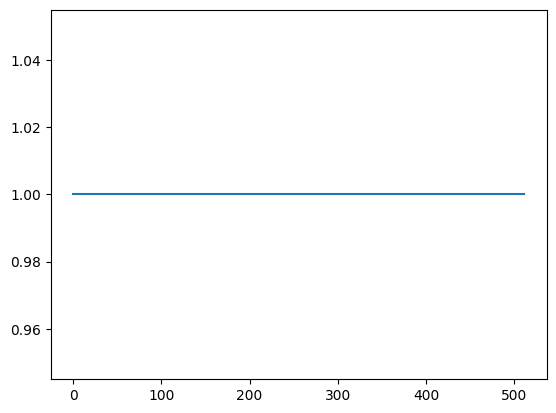

In [2]:
presence = np.zeros(2**nqbits, dtype=bool)
presence[basis] = True
plt.plot(presence)

In [3]:
result.dump('tmp.res')

In [4]:
aa = qat.core.Result.load('tmp.res')

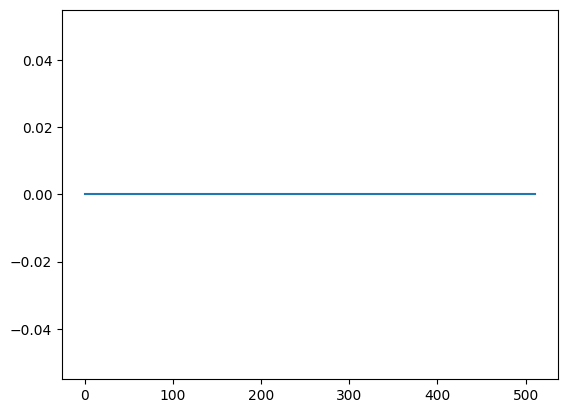

In [5]:
basis0 = np.arange(2**nqbits)
diff = np.array([i-j for i, j in zip(basis, basis0)])
import matplotlib.pyplot as plt
plt.plot(diff)

In [6]:
import numpy as np
from time import time
import pickle
import struc_fac as sf

L1, L2, statevector = pickle.load(open('quantum-data.pkl', 'rb'))
N = L1 * L2
hsize = 2**N
ibasis = sf.get_basis(hsize=hsize, N=N)
print(f'Read L1, L2 = ({L1}, {L2})')

t1 = time()
s_i = sf.get_spins(statevector, ibasis, N)
t2 = time()

print(f"Time in s_i compute = {t2 - t1}")
np.savetxt('final-si.dat', s_i)

t1 = time()
s_ij = sf.get_sisj(statevector, ibasis, N)
t2 = time()

pickle.dump(s_ij, open('classical-data.pkl', 'wb'))
print(f"Time in s_ij compute = {t2 - t1}")


t1 = time()
s_f = sf.struc_fac_from_sij(L1, L2, s_ij)
t2 = time()
print(f"Time in s_f compute = {t2 - t1}")


Read L1, L2 = (3, 3)
Time in s_i compute = 0.1094961166381836
Time in s_ij compute = 0.4579300880432129
Time in s_f compute = 0.00028705596923828125


In [ ]:
import numpy as np
from time import time
import pickle
import struc_fac as sf

L1, L2 = 3, 3
L1, L2, statevector = pickle.load(open('quantum-data-4x4.pkl', 'rb'))
N = L1 * L2
hsize = 2**N
ibasis = sf.get_basis(hsize=hsize, N=N)

"""
print(f'Read L1, L2 = ({L1}, {L2})')

t1 = time()
s_i = sf.get_spins(statevector, ibasis, N)
t2 = time()

print(f"Time in s_i compute = {t2 - t1}")
np.savetxt('final-si.dat', s_i)

t1 = time()
s_ij = sf.get_sisj(statevector, ibasis, N)
t2 = time()

pickle.dump(s_ij, open('classical-data.pkl', 'wb'))
print(f"Time in s_ij compute = {t2 - t1}")
"""

'\nprint(f\'Read L1, L2 = ({L1}, {L2})\')\n\nt1 = time()\ns_i = sf.get_spins(statevector, ibasis, N)\nt2 = time()\n\nprint(f"Time in s_i compute = {t2 - t1}")\nnp.savetxt(\'final-si.dat\', s_i)\n\nt1 = time()\ns_ij = sf.get_sisj(statevector, ibasis, N)\nt2 = time()\n\npickle.dump(s_ij, open(\'classical-data.pkl\', \'wb\'))\nprint(f"Time in s_ij compute = {t2 - t1}")\n'

In [5]:
statevector.shape, hsize

((63019,), 65536)

In [17]:
L = 3
s_ij.shape

(9, 9)

In [23]:
s_f = struc_fac_from_sij(3, 3, s_ij)

In [24]:
s_f

array([[0.02042698, 0.02042698, 0.02042698],
       [0.02042698, 0.02042698, 0.02042698],
       [0.02042698, 0.02042698, 0.02042698]])